Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train tensor size torch.Size([100, 512])
dev tensor size torch.Size([100, 512])
train label size 100
dev label size 100


Training: 100%|██████████| 25/25 [00:15<00:00,  1.66it/s]


Iteration 0 Loss: 0.12509627074003218


Predicting: 100%|██████████| 25/25 [00:02<00:00, 10.54it/s]


dev accuracy: tensor(0.8800)
dev precision: tensor(0.8393)
dev recall: tensor(0.9400)
dev f1: tensor(0.8868)


Training: 100%|██████████| 25/25 [00:07<00:00,  3.52it/s]


Iteration 1 Loss: 0.0742038594186306


Predicting: 100%|██████████| 25/25 [00:02<00:00, 10.49it/s]


dev accuracy: tensor(0.9400)
dev precision: tensor(0.9231)
dev recall: tensor(0.9600)
dev f1: tensor(0.9412)


Training: 100%|██████████| 25/25 [00:07<00:00,  3.50it/s]


Iteration 2 Loss: 0.054633531123399734


Predicting: 100%|██████████| 25/25 [00:02<00:00, 10.44it/s]


dev accuracy: tensor(0.9500)
dev precision: tensor(0.9245)
dev recall: tensor(0.9800)
dev f1: tensor(0.9515)


Training: 100%|██████████| 25/25 [00:07<00:00,  3.49it/s]


Iteration 3 Loss: 0.04596882224082947


Predicting: 100%|██████████| 25/25 [00:02<00:00, 10.40it/s]


dev accuracy: tensor(0.9400)
dev precision: tensor(0.9231)
dev recall: tensor(0.9600)
dev f1: tensor(0.9412)


Training: 100%|██████████| 25/25 [00:07<00:00,  3.47it/s]


Iteration 4 Loss: 0.04430128134787083


Predicting: 100%|██████████| 25/25 [00:02<00:00, 10.37it/s]


dev accuracy: tensor(0.9600)
dev precision: tensor(0.9423)
dev recall: tensor(0.9800)
dev f1: tensor(0.9608)


Training: 100%|██████████| 25/25 [00:07<00:00,  3.43it/s]


Iteration 5 Loss: 0.03854457285255194


Predicting: 100%|██████████| 25/25 [00:02<00:00, 10.32it/s]


dev accuracy: tensor(0.9600)
dev precision: tensor(0.9423)
dev recall: tensor(0.9800)
dev f1: tensor(0.9608)


Training: 100%|██████████| 25/25 [00:07<00:00,  3.45it/s]


Iteration 6 Loss: 0.03228410938754678


Predicting: 100%|██████████| 25/25 [00:02<00:00, 10.29it/s]


dev accuracy: tensor(0.9700)
dev precision: tensor(0.9608)
dev recall: tensor(0.9800)
dev f1: tensor(0.9703)


Training: 100%|██████████| 25/25 [00:07<00:00,  3.44it/s]


Iteration 7 Loss: 0.030599437542259692


Predicting: 100%|██████████| 25/25 [00:02<00:00, 10.26it/s]


dev accuracy: tensor(0.9700)
dev precision: tensor(0.9608)
dev recall: tensor(0.9800)
dev f1: tensor(0.9703)


Training: 100%|██████████| 25/25 [00:07<00:00,  3.42it/s]


Iteration 8 Loss: 0.026072019189596177


Predicting: 100%|██████████| 25/25 [00:02<00:00, 10.18it/s]


dev accuracy: tensor(0.9700)
dev precision: tensor(0.9608)
dev recall: tensor(0.9800)
dev f1: tensor(0.9703)


Training: 100%|██████████| 25/25 [00:07<00:00,  3.39it/s]


Iteration 9 Loss: 0.02438297376036644


Predicting: 100%|██████████| 25/25 [00:02<00:00, 10.04it/s]

dev accuracy: tensor(0.9700)
dev precision: tensor(0.9608)
dev recall: tensor(0.9800)
dev f1: tensor(0.9703)


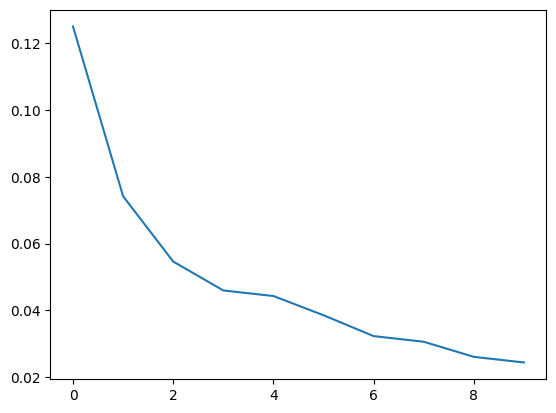

In [ ]:
import pickle
import torch
from helper import tokenize, forward_ab, f1_score, accuracy, precision, recall
import pandas as pd
import random
from tqdm import tqdm
import os
from models import CrossEncoder
from collections import defaultdict
import matplotlib.pyplot as plt

def make_proposition_map(dataset):
    data = f'./Data/{dataset}.csv'
    df = pd.read_csv(data)
    prop_dict = defaultdict(dict)
    for x, y in enumerate(df.iterrows()):

        prop_dict[x]['common_ground'] = df['Common Ground'][x]
        prop_dict[x]['transcript'] = df['Transcript'][x]
        prop_dict[x]['label'] = df['Label'][x]
    return prop_dict, df


def add_special_tokens(proposition_map):
    for x, y in proposition_map.items():
        #print(y['common_ground'])
        cg_with_token = "<m>" + " " + y['common_ground']+ " "  + "</m>"
        prop_with_token = "<m>" + " "+ y['transcript'] +" " + "</m>"
        proposition_map[x]['common_ground'] = cg_with_token
        proposition_map[x]['transcript'] = prop_with_token
    return proposition_map

def predict_with_XE(parallel_model, dev_ab, dev_ba, device, batch_size):
    n = dev_ab['input_ids'].shape[0]
    indices = list(range(n))
    # new_batch_size = batching(n, batch_size, len(device_ids))
    # batch_size = new_batch_size
    all_scores_ab = []
    all_scores_ba = []
    with torch.no_grad():
        for i in tqdm(range(0, n, batch_size), desc='Predicting'):
            batch_indices = indices[i: i + batch_size]
            scores_ab = forward_ab(parallel_model, dev_ab, device, batch_indices)
            scores_ba = forward_ab(parallel_model, dev_ba, device, batch_indices)
            all_scores_ab.append(scores_ab.detach().cpu())
            all_scores_ba.append(scores_ba.detach().cpu())

    return torch.cat(all_scores_ab), torch.cat(all_scores_ba)


def train_prop_XE(dataset, model_name=None):
    dataset_folder = f'./datasets/{dataset}/'
    device = torch.device('cuda:0')
    device_ids = list(range(1))
    #load the statement and proposition data
    prop_dict, df = make_proposition_map("Dataset_Updated")
    proposition_map = add_special_tokens(prop_dict)
    
    train_pairs  = [x for x in proposition_map.keys()]
    train_labels = [y['label'] for x,y in proposition_map.items()]

    dev_pairs = [x for x in proposition_map.keys()]
    dev_labels = [y['label'] for x,y in proposition_map.items()]
    
    #try a sample unit test with a smaller pos/neg set
    train_pairs =train_pairs[0:50] + train_pairs[-50:] # 50 pos and 50 neg labels
    train_labels = train_labels[0:50] + train_labels[-50:] 
    dev_pairs = dev_pairs[0:50] + dev_pairs[-50:]  # 50 pos and 50 neg labels
    dev_labels = dev_labels[0:50] + dev_labels[-50:]
    print(train_pairs)
    
    model_name = 'roberta-base'
    scorer_module = CrossEncoder(is_training=True,long=False,  model_name=model_name).to(device)

    parallel_model = torch.nn.DataParallel(scorer_module, device_ids=device_ids)
    parallel_model.module.to(device)
    train(train_pairs, train_labels, train_pairs, train_labels, parallel_model, proposition_map, dataset_folder, device,
          batch_size=4, n_iters=10, lr_lm=0.000001, lr_class=0.0001)
  
def tokenize_props(tokenizer, proposition_ids, proposition_map, m_end, max_sentence_len=1024, truncate=True):
    if max_sentence_len is None:
        max_sentence_len = tokenizer.model_max_length

    pairwise_bert_instances_ab = []
    pairwise_bert_instances_ba = []

    doc_start = '<doc-s>'
    doc_end = '</doc-s>'

    for index in proposition_ids:
        sentence_a = proposition_map[index]['transcript']
        sentence_b = proposition_map[index]['common_ground']

        def make_instance(sent_a, sent_b):
            return ' '.join(['<g>', doc_start, sent_a, doc_end]), \
                   ' '.join([doc_start, sent_b, doc_end])

        instance_ab = make_instance(sentence_a, sentence_b)
        pairwise_bert_instances_ab.append(instance_ab)

        instance_ba = make_instance(sentence_b, sentence_a)
        pairwise_bert_instances_ba.append(instance_ba)

    def truncate_with_mentions(input_ids):
        input_ids_truncated = []
        for input_id in input_ids:
            m_end_index = input_id.index(m_end)

            curr_start_index = max(0, m_end_index - (max_sentence_len // 4))

            in_truncated = input_id[curr_start_index: m_end_index] + \
                           input_id[m_end_index: m_end_index + (max_sentence_len // 4)]
            in_truncated = in_truncated + [tokenizer.pad_token_id] * (max_sentence_len // 2 - len(in_truncated))
            input_ids_truncated.append(in_truncated)

        return torch.LongTensor(input_ids_truncated)

    def ab_tokenized(pair_wise_instances):
        instances_a, instances_b = zip(*pair_wise_instances)

        tokenized_a = tokenizer(list(instances_a), add_special_tokens=False)
        tokenized_b = tokenizer(list(instances_b), add_special_tokens=False)

        tokenized_a = truncate_with_mentions(tokenized_a['input_ids'])
        positions_a = torch.arange(tokenized_a.shape[-1]).expand(tokenized_a.shape)
        tokenized_b = truncate_with_mentions(tokenized_b['input_ids'])
        positions_b = torch.arange(tokenized_b.shape[-1]).expand(tokenized_b.shape)

        tokenized_ab_ = torch.hstack((tokenized_a, tokenized_b))
        positions_ab = torch.hstack((positions_a, positions_b))

        tokenized_ab_dict = {'input_ids': tokenized_ab_,
                             'attention_mask': (tokenized_ab_ != tokenizer.pad_token_id),
                             'position_ids': positions_ab
                             }

        return tokenized_ab_dict

    if truncate:
        tokenized_ab = ab_tokenized(pairwise_bert_instances_ab)
        tokenized_ba = ab_tokenized(pairwise_bert_instances_ba)
    else:
        instances_ab = [' '.join(instance) for instance in pairwise_bert_instances_ab]
        instances_ba = [' '.join(instance) for instance in pairwise_bert_instances_ba]
        tokenized_ab = tokenizer(list(instances_ab), add_special_tokens=False, padding=True)

        tokenized_ab_input_ids = torch.LongTensor(tokenized_ab['input_ids'])

        tokenized_ab = {'input_ids': torch.LongTensor(tokenized_ab['input_ids']),
                         'attention_mask': torch.LongTensor(tokenized_ab['attention_mask']),
                         'position_ids': torch.arange(tokenized_ab_input_ids.shape[-1]).expand(tokenized_ab_input_ids.shape)}

        tokenized_ba = tokenizer(list(instances_ba), add_special_tokens=False, padding=True)
        tokenized_ba_input_ids = torch.LongTensor(tokenized_ba['input_ids'])
        tokenized_ba = {'input_ids': torch.LongTensor(tokenized_ba['input_ids']),
                        'attention_mask': torch.LongTensor(tokenized_ba['attention_mask']),
                        'position_ids': torch.arange(tokenized_ba_input_ids.shape[-1]).expand(tokenized_ba_input_ids.shape)}

    return tokenized_ab, tokenized_ba    
    

    
def train(train_pairs,
          train_labels,
          dev_pairs,
          dev_labels,
          parallel_model,
          proposition_map,
          working_folder,
          device,
          batch_size=4,
          n_iters=50,
          lr_lm=0.00001,
          lr_class=0.001):
    bce_loss = torch.nn.BCELoss()
    # mse_loss = torch.nn.MSELoss()

    optimizer = torch.optim.AdamW([
        {'params': parallel_model.module.model.parameters(), 'lr': lr_lm},
        {'params': parallel_model.module.linear.parameters(), 'lr': lr_class}
    ])

    # all_examples = load_easy_hard_data(trivial_non_trivial_path)
    # train_pairs, dev_pairs, train_labels, dev_labels = split_data(all_examples, dev_ratio=dev_ratio)

    tokenizer = parallel_model.module.tokenizer

    # prepare data
    train_ab, train_ba = tokenize_props(tokenizer, train_pairs, proposition_map, parallel_model.module.end_id, max_sentence_len=512)
    dev_ab, dev_ba = tokenize_props(tokenizer, train_pairs, proposition_map, parallel_model.module.end_id, max_sentence_len=512)
   
    #labels
    train_labels = torch.FloatTensor(train_labels)
    dev_labels = torch.LongTensor(dev_labels)
    print("train tensor size",train_ab['input_ids'].size())
    print("dev tensor size",dev_ab['input_ids'].size())
    print("train label size", len(train_labels))
    print("dev label size", len(dev_labels))
    train_loss = []
    for n in range(n_iters):
        break
        train_indices = list(range(len(train_pairs)))
        random.shuffle(train_indices)
        iteration_loss = 0.
        # new_batch_size = batching(len(train_indices), batch_size, len(device_ids))
        new_batch_size = batch_size
        for i in tqdm(range(0, len(train_indices), new_batch_size), desc='Training'):
            optimizer.zero_grad()
            batch_indices = train_indices[i: i + new_batch_size]

            scores_ab = forward_ab(parallel_model, train_ab, device, batch_indices)
            scores_ba = forward_ab(parallel_model, train_ba, device, batch_indices)

            batch_labels = train_labels[batch_indices].reshape((-1, 1)).to(device)

            scores_mean = (scores_ab + scores_ba) / 2

            loss = bce_loss(scores_mean, batch_labels)

            loss.backward()

            optimizer.step()

            iteration_loss += loss.item()

        print(f'Iteration {n} Loss:', iteration_loss / len(train_pairs))
        train_loss.append(iteration_loss / len(train_pairs))
        # iteration accuracy
        dev_scores_ab, dev_scores_ba = predict_with_XE(parallel_model, dev_ab, dev_ba, device, batch_size)
        dev_predictions = (dev_scores_ab + dev_scores_ba)/2
        dev_predictions = dev_predictions > 0.5
        dev_predictions = torch.squeeze(dev_predictions)

        print("dev accuracy:", accuracy(dev_predictions, dev_labels))
        print("dev precision:", precision(dev_predictions, dev_labels))
        print("dev recall:", recall(dev_predictions, dev_labels))
        print("dev f1:", f1_score(dev_predictions, dev_labels))
    plt.plot(train_loss)
    plt.show()
#         if n % 2 == 0:
#             scorer_folder = working_folder + f'/XE_scorer/chk_{n}'
#             if not os.path.exists(scorer_folder):
#                 os.makedirs(scorer_folder)
#             model_path = scorer_folder + '/linear.chkpt'
#             torch.save(parallel_model.module.linear.state_dict(), model_path)
#             parallel_model.module.model.save_pretrained(scorer_folder + '/bert')
#             parallel_model.module.tokenizer.save_pretrained(scorer_folder + '/bert')
#             print(f'saved model at {n}')

#     scorer_folder = working_folder + '/XE_scorer/'
#     if not os.path.exists(scorer_folder):
#         os.makedirs(scorer_folder)
#     model_path = scorer_folder + '/linear.chkpt'
#     torch.save(parallel_model.module.linear.state_dict(), model_path)
#     parallel_model.module.model.save_pretrained(scorer_folder + '/bert')
#     parallel_model.module.tokenizer.save_pretrained(scorer_folder + '/bert')


if __name__ == '__main__':
    train_prop_XE('ecb', model_name='roberta-base')


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))